In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from scipy import stats

In [2]:
dta = pd.read_excel("SP500_daily.xlsx")

In [3]:
dta

,Datum,Price
0,1982-09-20,122.55
1,1982-09-21,122.51
2,1982-09-22,124.88
3,1982-09-23,123.99
4,1982-09-24,123.81
...,...,...
10025,2021-02-22,3885.55
10026,2021-02-23,3857.07
10027,2021-02-24,3873.71
10028,2021-02-25,3915.80


In [4]:
dta.index = pd.DatetimeIndex(dta.Datum)

In [5]:
dta

,Datum,Price
Datum,,
1982-09-20,1982-09-20,122.55
1982-09-21,1982-09-21,122.51
1982-09-22,1982-09-22,124.88
1982-09-23,1982-09-23,123.99
1982-09-24,1982-09-24,123.81
...,...,...
2021-02-22,2021-02-22,3885.55
2021-02-23,2021-02-23,3857.07
2021-02-24,2021-02-24,3873.71


In [9]:
dta['year'] = dta.Datum.dt.year

In [11]:
dta['month'] = dta.Datum.dt.month

## Compute Log Return

In [12]:
dta2 = dta.groupby(['year', 'month']).last()

In [13]:
dta2

Datum    Price
year month                    
1982 9     1982-09-30   121.63
     10    1982-10-29   133.59
     11    1982-11-30   134.20
     12    1982-12-31   140.33
1983 1     1983-01-31   144.51
...               ...      ...
2020 10    2020-10-30  3293.59
     11    2020-11-30  3634.18
     12    2020-12-31  3733.27
2021 1     2021-01-29  3778.05
     2     2021-02-26  3839.66

[462 rows x 2 columns]

In [92]:
dta_hamilton2 = dta2[['Datum', 'Price']]

In [181]:
#dta_hamilton2['Price'] = np.log(dta2.Price/dta2.Price.shift(1))
dta_hamilton2['Price'] = dta2.Price/dta2.Price.shift(1)-1

In [182]:
dta_hamilton = dta_hamilton2.reset_index().drop(['year', 'month'], axis = 1).set_index('Datum')

In [183]:
dta_hamilton.iloc[0:20,]

,Price
Datum,
1982-09-30,NaN
1982-10-29,0.098331
1982-11-30,0.004566
1982-12-31,0.045678
1983-01-31,0.029787
1983-02-28,0.036191
1983-03-31,0.024376
1983-04-29,0.062325
1983-05-31,0.009267


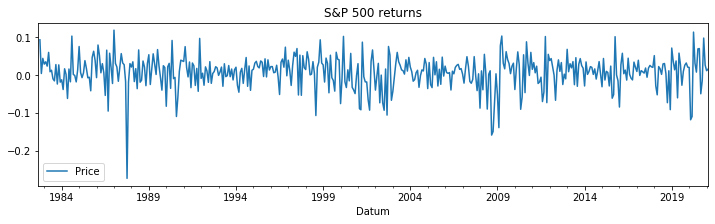

In [96]:
# Plot the data
dta_hamilton.plot(title='S&P 500 returns', figsize=(12,3))

## Test Normality - Jarque-Bera & D’Agostino and Pearson’s - H_0 = normal distribution

In [184]:
jarque_bera_test = stats.jarque_bera(dta_hamilton.Price.dropna())

In [185]:
jarque_bera_test

(203.26377543270343, 0.0)

In [186]:
k2, p = stats.normaltest(dta_hamilton.dropna())

In [187]:
p

array([4.57334277e-17])

### Normalverteilungshypothese wird verworfen

# Estimate Markov Switching Models with 2 regimes

In [188]:
test = sm.tsa.MarkovRegression(dta_hamilton.dropna(), k_regimes=2, switching_variance=True)

/Users/vanessatheel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  % freq, ValueWarning)


In [189]:
test_3 = sm.tsa.MarkovRegression(dta_hamilton.dropna(), k_regimes=3, switching_variance=True)

/Users/vanessatheel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  % freq, ValueWarning)


In [190]:
regimes_iter = test.fit(full_output= True, em_iter=5, search_reps=5, search_iter = 5)

In [191]:
regimes = test.fit()

In [192]:
regimes_3 = test_3.fit()

In [193]:
regimes_3.summary()

/Users/vanessatheel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  Price   No. Observations:                  461
Model:               MarkovRegression   Log Likelihood                 837.065
Date:                Mon, 22 Mar 2021   AIC                          -1650.130
Time:                        13:19:01   BIC                          -1600.529
Sample:                    10-29-1982   HQIC                         -1630.600
                         - 02-26-2021                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0237      0.003      7.643      0.000       0.018       0.030
sigma2         0.0001   6.23e-05      2.353      0.019    2.45e-05       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0099      0.003      2.972      0.003       0.003       0.016
sigma2         0.0009      0.000      5.262      0.000       0.001       0.001
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.006     -0.199      0.842      -0.013       0.010
sigma2         0.0037      0.001      6.907      0.000       0.003       0.005
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.0271      0.166      0.163      0.871      -0.299       0.353
p[1->0]        0.3061      0.157      1.950      0.051      -0.002       0.614
p[2->0]        0.1203      0.044      2.735      0.006       0.034       0.206
p[0->1]        0.8837      0.254      3.474      0.001       0.385       1.382
p[1->1]        0.6334      0.169      3.754      0.000       0.303       0.964
p[2->1]     3.388e-17        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [234]:
dta_hamilton.Price.std()*100

4.330217746583006

In [195]:
regimes.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  Price   No. Observations:                  461
Model:               MarkovRegression   Log Likelihood                 830.774
Date:                Mon, 22 Mar 2021   AIC                          -1649.548
Time:                        13:19:11   BIC                          -1624.748
Sample:                    10-29-1982   HQIC                         -1639.783
                         - 02-26-2021                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0142      0.002      7.550      0.000       0.010       0.018
sigma2         0.0007   9.67e-05      7.396      0.000       0.001       0.001
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.006     -0.204      0.838      -0.012       0.010
sigma2         0.0037      0.001      6.908      0.000       0.003       0.005
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9270      0.027     34.972      0.000       0.875       0.979
p[1->0]        0.1228      0.051      2.410      0.016       0.023       0.223
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [104]:
regimes_iter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  Price   No. Observations:                  461
Model:               MarkovRegression   Log Likelihood                 831.507
Date:                Mon, 22 Mar 2021   AIC                          -1651.014
Time:                        10:07:31   BIC                          -1626.213
Sample:                    10-29-1982   HQIC                         -1641.249
                         - 02-26-2021                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0062      0.007     -0.947      0.344      -0.019       0.007
sigma2         0.0041      0.001      6.822      0.000       0.003       0.005
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0142      0.002      7.909      0.000       0.011       0.018
sigma2         0.0007    9.8e-05      7.495      0.000       0.001       0.001
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.8545      0.057     15.105      0.000       0.744       0.965
p[1->0]        0.0717      0.026      2.715      0.007       0.020       0.123
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

# Look at marginal probabilities

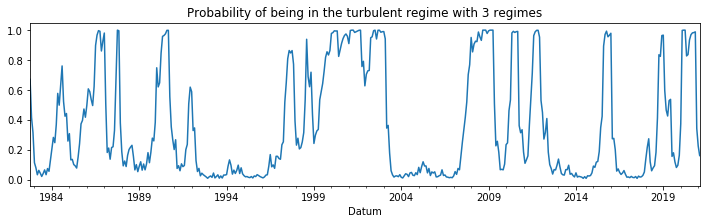

In [196]:
regimes_3.smoothed_marginal_probabilities[2].plot(
    title='Probability of being in the turbulent regime with 3 regimes', figsize=(12,3))

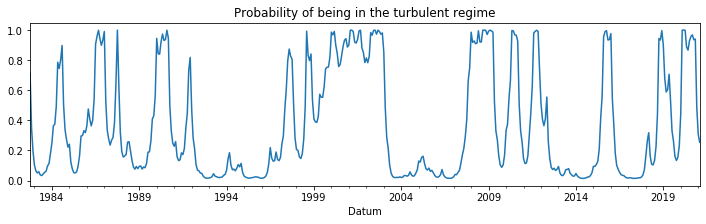

In [197]:
regimes.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in the turbulent regime', figsize=(12,3))

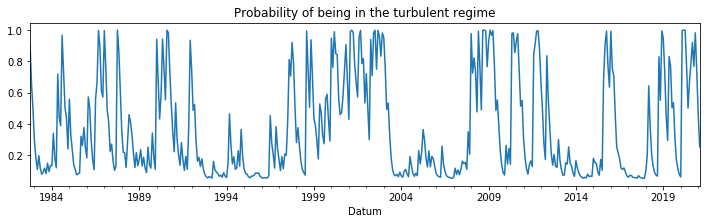

In [198]:
regimes.filtered_marginal_probabilities[1].plot(
    title='Probability of being in the turbulent regime', figsize=(12,3))

In [199]:
turb = regimes.smoothed_marginal_probabilities[regimes.smoothed_marginal_probabilities[1] > regimes.smoothed_marginal_probabilities[0]]

In [200]:
turb_3 = regimes_3.smoothed_marginal_probabilities[(regimes_3.smoothed_marginal_probabilities[2] > regimes_3.smoothed_marginal_probabilities[0]) & (regimes_3.smoothed_marginal_probabilities[2] > regimes_3.smoothed_marginal_probabilities[1])]

In [201]:
rest0_3 = regimes_3.smoothed_marginal_probabilities[(regimes_3.smoothed_marginal_probabilities[0] > regimes_3.smoothed_marginal_probabilities[2]) & (regimes_3.smoothed_marginal_probabilities[0] > regimes_3.smoothed_marginal_probabilities[1])]

In [202]:
rest1_3 = regimes_3.smoothed_marginal_probabilities[(regimes_3.smoothed_marginal_probabilities[1] > regimes_3.smoothed_marginal_probabilities[0]) & (regimes_3.smoothed_marginal_probabilities[1] > regimes_3.smoothed_marginal_probabilities[2])]

In [203]:
rest = regimes.smoothed_marginal_probabilities[regimes.smoothed_marginal_probabilities[1] < regimes.smoothed_marginal_probabilities[0]]

In [204]:
rest_3 = regimes_3.smoothed_marginal_probabilities[(regimes_3.smoothed_marginal_probabilities[2] < regimes_3.smoothed_marginal_probabilities[0]) | (regimes_3.smoothed_marginal_probabilities[2] < regimes_3.smoothed_marginal_probabilities[1])]

## Check normality in regimes

In [205]:
dta_hamilton

,Price
Datum,
1982-09-30,NaN
1982-10-29,0.098331
1982-11-30,0.004566
1982-12-31,0.045678
1983-01-31,0.029787
...,...
2020-10-30,-0.014252
2020-11-30,0.103410
2020-12-31,0.027266


In [206]:
turb.index

DatetimeIndex(['1982-10-29', '1984-05-31', '1984-06-29', '1984-07-31',
               '1984-08-31', '1984-09-28', '1986-06-30', '1986-07-31',
               '1986-08-29', '1986-09-30',
               ...
               '2020-02-28', '2020-03-31', '2020-04-30', '2020-05-29',
               '2020-06-30', '2020-07-31', '2020-08-31', '2020-09-30',
               '2020-10-30', '2020-11-30'],
              dtype='datetime64[ns]', name='Datum', length=149, freq=None)

In [207]:
dta_hamilton.loc[turb.index,'Price']

Datum
1982-10-29    0.098331
1984-05-31   -0.059666
1984-06-29    0.016561
1984-07-31   -0.017338
1984-08-31    0.109262
                ...   
2020-07-31    0.072208
2020-08-31    0.073164
2020-09-30   -0.048015
2020-10-30   -0.014252
2020-11-30    0.103410
Name: Price, Length: 149, dtype: float64

### 2 regimes

In [208]:
jarque_bera_test = stats.jarque_bera(dta_hamilton.loc[turb.index, 'Price'])

In [209]:
jarque_bera_test

(1.7353124948598224, 0.419934619604754)

In [210]:
k2, p = stats.normaltest(dta_hamilton.loc[turb.index, 'Price'])

In [211]:
p

0.3634946782976979

In [212]:
jarque_bera_test = stats.jarque_bera(dta_hamilton.loc[rest.index, 'Price'])

In [213]:
jarque_bera_test

(0.669227573513483, 0.7156144127519393)

In [214]:
k2, p = stats.normaltest(dta_hamilton.loc[rest.index, 'Price'])

In [215]:
p

0.7619939474097762

In [216]:
turb

,0,1
Datum,,
1982-10-29,0.288410,0.711590
1984-05-31,0.213830,0.786170
1984-06-29,0.255042,0.744958
1984-07-31,0.197562,0.802438
1984-08-31,0.101903,0.898097
...,...,...
2020-07-31,0.070748,0.929252
2020-08-31,0.042116,0.957884
2020-09-30,0.031550,0.968450


### 3 regimes

In [217]:
jarque_bera_test = stats.jarque_bera(dta_hamilton.loc[turb_3.index, 'Price'])

In [218]:
jarque_bera_test

(3.37537483178233, 0.18494673470189837)

In [219]:
k2, p = stats.normaltest(dta_hamilton.loc[turb_3.index, 'Price'])

In [220]:
p

0.14635789844992525

In [221]:
jarque_bera_test = stats.jarque_bera(dta_hamilton.loc[rest0_3.index, 'Price'])

In [222]:
jarque_bera_test

(1.4931873847551351, 0.47397832206282475)

In [223]:
k2, p = stats.normaltest(dta_hamilton.loc[rest0_3.index, 'Price'])

In [224]:
p

0.4574423176129968

In [225]:
jarque_bera_test = stats.jarque_bera(dta_hamilton.loc[rest1_3.index, 'Price'])

In [226]:
jarque_bera_test

(2.0404389156320764, 0.360515813477837)

In [227]:
k2, p = stats.normaltest(dta_hamilton.loc[rest1_3.index, 'Price'])

In [228]:
p

0.2798356224707669

## Split 2 regimes --> Turb high and Turb low

In [229]:
dta_hamilton.loc[rest.index, 'Price'].mean()*100

1.4167251070157603

In [230]:
dta_hamilton.loc[rest.index, 'Price'].std()*100

2.601496823849555

In [231]:
test2 = sm.tsa.MarkovRegression(dta_hamilton.loc[turb.index, 'Price'].dropna(), k_regimes=2, switching_variance=True)

/Users/vanessatheel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [158]:
regimes2 = test2.fit()

/Users/vanessatheel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [159]:
regimes2.summary()

/Users/vanessatheel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  Price   No. Observations:                  130
Model:               MarkovRegression   Log Likelihood                 192.163
Date:                Mon, 22 Mar 2021   AIC                           -372.326
Time:                        10:40:02   BIC                           -355.120
Sample:                             0   HQIC                          -365.335
                                - 130                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2733   2.52e-13  -1.09e+12      0.000      -0.273      -0.273
sigma2      3.171e-26   2.52e-13   1.26e-13      1.000   -4.94e-13    4.94e-13
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039        nan        nan        nan         nan         nan
sigma2         0.0042        nan        nan        nan         nan         nan
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.1358        nan        nan        nan         nan         nan
p[1->0]        0.0098        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 3.29e+29. Standard errors may be unstable.
"""

# Plot Turbulences

In [144]:
from statsmodels.tsa.regime_switching.tests.test_markov_regression import areturns

In [145]:
dta2

Datum    Price
year month                    
1982 9     1982-09-30   121.63
     10    1982-10-29   133.59
     11    1982-11-30   134.20
     12    1982-12-31   140.33
1983 1     1983-01-31   144.51
...               ...      ...
2020 10    2020-10-30  3293.59
     11    2020-11-30  3634.18
     12    2020-12-31  3733.27
2021 1     2021-01-29  3778.05
     2     2021-02-26  3839.66

[462 rows x 2 columns]

In [237]:
for i in range(0,len(turb.index)):
    print(turb.index[i])

1982-10-29 00:00:00
1984-05-31 00:00:00
1984-06-29 00:00:00
1984-07-31 00:00:00
1984-08-31 00:00:00
1984-09-28 00:00:00
1986-06-30 00:00:00
1986-07-31 00:00:00
1986-08-29 00:00:00
1986-09-30 00:00:00
1986-10-31 00:00:00
1986-11-28 00:00:00
1986-12-31 00:00:00
1987-01-30 00:00:00
1987-02-27 00:00:00
1987-09-30 00:00:00
1987-10-30 00:00:00
1987-11-30 00:00:00
1989-12-29 00:00:00
1990-01-31 00:00:00
1990-02-28 00:00:00
1990-03-30 00:00:00
1990-04-30 00:00:00
1990-05-31 00:00:00
1990-06-29 00:00:00
1990-07-31 00:00:00
1990-08-31 00:00:00
1990-09-28 00:00:00
1990-10-31 00:00:00
1991-11-29 00:00:00
1991-12-31 00:00:00
1997-06-30 00:00:00
1997-07-31 00:00:00
1997-08-29 00:00:00
1997-09-30 00:00:00
1997-10-31 00:00:00
1997-11-28 00:00:00
1998-08-31 00:00:00
1998-09-30 00:00:00
1998-10-30 00:00:00
1998-11-30 00:00:00
1998-12-31 00:00:00
1999-05-31 00:00:00
1999-06-30 00:00:00
1999-07-30 00:00:00
1999-08-31 00:00:00
1999-09-30 00:00:00
1999-10-29 00:00:00
1999-11-30 00:00:00
1999-12-31 00:00:00


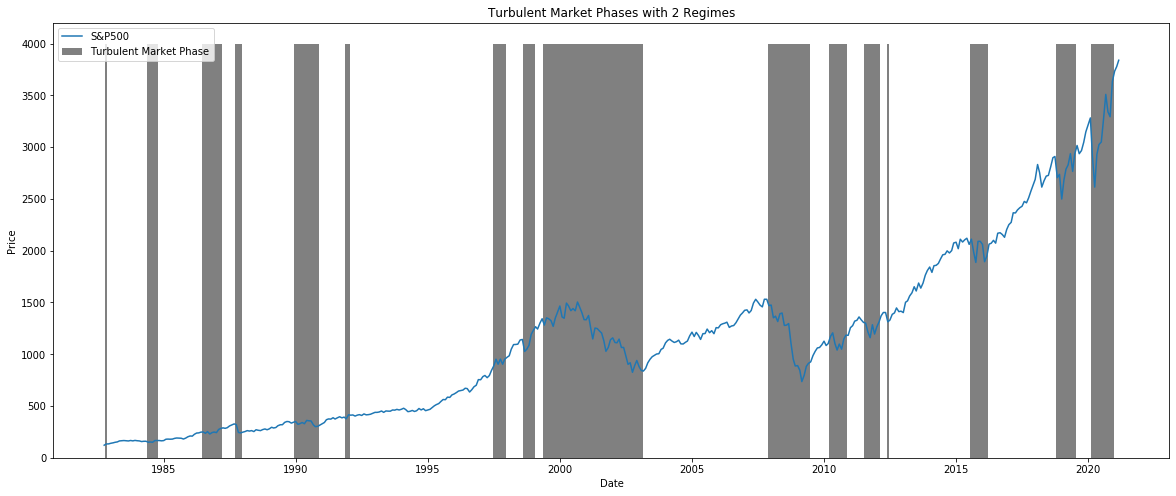

In [232]:
plt.figure(figsize=(20,8))
plt.plot(dta2.Datum, dta2.Price, label = 'S&P500')
plt.bar(turb.index, 4000, color= 'grey', width = 32, label = 'Turbulent Market Phase')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title("Turbulent Market Phases with 2 Regimes")
plt.legend()
plt.show()

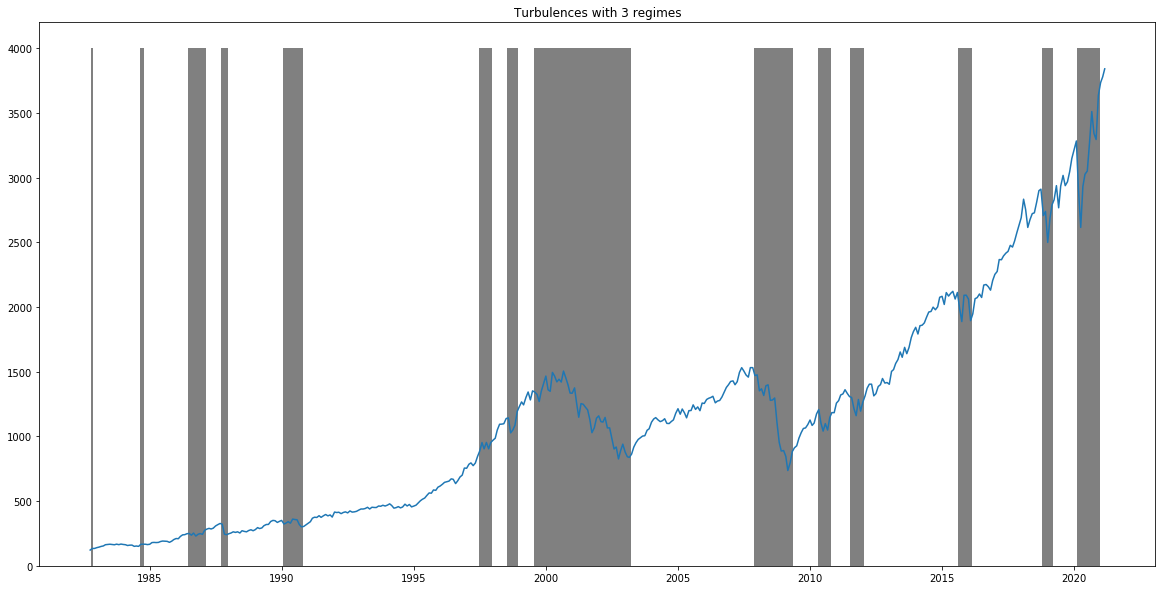

In [151]:
plt.figure(figsize=(20,10))
plt.plot(dta2.Datum, dta2.Price)
plt.bar(turb_3.index, 4000, color= 'grey', width = 32)
plt.ylabel('Price')
plt.xlabel('Date')
plt.title("Turbulent Market Phases with 3 Regimes")
plt.legend()
plt.show()

In [98]:
dir(regimes)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_cov_approx_centered',
 '_cov_approx_complex_step',
 '_data_attr',
 '_get_robustcov_results',
 '_rank',
 '_use_t',
 'aic',
 'bic',
 'bse',
 'conditional_loglikelihoods',
 'conf_int',
 'cov_kwds',
 'cov_params',
 'cov_params_approx',
 'cov_params_default',
 'cov_params_opg',
 'cov_params_robust',
 'cov_type',
 'data',
 'expected_durations',
 'f_test',
 'filter_results',
 'filtered_joint_probabilities',
 'filtered_marginal_probabilities',
 'fittedvalues',
 'forecast',
 'hqic',
 'initial_probabilities',
 'initialize',
 'joint_likelihoods',
 'joint_loglikelihoods',
 'k_constant',
 'k_regimes',
 'llf',
 'llf_obs',


# 2nd Approach - Find Turbulences

divided in blocks that are separated by days on which the respective stock index reaches a half-year high;

In [68]:
dta = pd.read_csv("/Users/vanessatheel/Downloads/^GSPC.csv")

In [69]:
dta

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-01-02,1111.920044,1118.849976,1105.079956,1108.479980,1108.479980,1153200000
1,2004-01-05,1108.479980,1122.219971,1108.479980,1122.219971,1122.219971,1578200000
2,2004-01-06,1122.219971,1124.459961,1118.439941,1123.670044,1123.670044,1494500000
3,2004-01-07,1123.670044,1126.329956,1116.449951,1126.329956,1126.329956,1704900000
4,2004-01-08,1126.329956,1131.920044,1124.910034,1131.920044,1131.920044,1868400000
...,...,...,...,...,...,...,...
4274,2020-12-23,3693.419922,3711.239990,3689.280029,3690.010010,3690.010010,3772630000
4275,2020-12-24,3694.030029,3703.820068,3689.320068,3703.060059,3703.060059,1885090000
4276,2020-12-28,3723.030029,3740.510010,3723.030029,3735.360107,3735.360107,3527460000
4277,2020-12-29,3750.010010,3756.120117,3723.310059,3727.040039,3727.040039,3387030000


In [70]:
dta.index = pd.DatetimeIndex(dta.Date)

In [58]:
from datetime import date, timedelta

In [59]:
def high26(data):
    highs = pd.DataFrame(index=data.index,columns=['wh26'])
    highs.wh26 = False
    # only start after first 26 weeks of 5 working days are over
    for i in data.index[26*5:]:
        if max(data.loc[(i-timedelta(26*7)):i, ]) == data.loc[i,]:
            highs.loc[i,] = True
            
    return highs[highs.wh26 == True].index

In [61]:
highs = high26(dta.Price)

In [62]:
highs

DatetimeIndex(['1985-05-14', '1985-05-21', '1985-07-16', '1985-07-23',
               '1985-11-12', '1985-11-19', '1985-11-26', '1985-12-03',
               '1985-12-10', '1985-12-17',
               ...
               '2020-11-10', '2020-11-17', '2020-12-01', '2020-12-08',
               '2020-12-22', '2020-12-29', '2021-01-12', '2021-01-26',
               '2021-02-09', '2021-02-16'],
              dtype='datetime64[ns]', name='Datum', length=439, freq=None)

A crisis between two 26 week highs requires a minimum loss of 20% relative to the first 26 week high

In [63]:
def core_crisis_dates(data, highs):
    
    ccd = list()
    # a) find core crisis dates
    for i in range(0, (len(highs)-1)):
        #print(highs[i])
        help_ = data.loc[highs[i]:(highs[i+1]+timedelta(1)), ]/data[highs[i]]
        help__ = help_[help_ <= 0.8].index
    
        
        # b) if there is a core crisis date: find start and end
        if len(help__) > 0:
            
            # find lowest index value before next 26 week high is reached
            t_low = help_.idxmin()
            
            # starting date of the crisis is set to the 
            # last day on which the 10% loss level is passed before the first core crisis data is reached
            help_2 = help_[:(help__[0]+timedelta(1))]
            t_start = max(help_2[help_2 > 0.9].index) +timedelta(1)
            
            try:        
                t_downend = list()
                for k in range(t_low, (highs[i+1]+timedelta(1))):
                    help_3 = data.loc[k,]/ data.loc[t_low:k, ]
                    if (help_3 <= 0.9).any:
                        t_downend.extend(help_3[help_3 <= 0.9].idxmax())
                t_downend = max(t_downend)
                
                help_4 = data.loc[t_downend,] / data.loc[t_low:t_downend, ]
                t_downstart = help_4[help_4 <= 0.9].idxmax()
                
                t_down = data.loc[t_downstart:(t_downend +timedelta(1)),].idxmin()
            except:
                t_down = t_low
            
            ccd.extend(pd.date_range(t_start,t_down))
            #ccd.append([t_start, t_down])
        else:
            pass
        
    return ccd

In [64]:
ccds = core_crisis_dates(dta.Price, highs)

In [65]:
ccds

[Timestamp('1987-10-14 00:00:00', freq='D'),
 Timestamp('1987-10-15 00:00:00', freq='D'),
 Timestamp('1987-10-16 00:00:00', freq='D'),
 Timestamp('1987-10-17 00:00:00', freq='D'),
 Timestamp('1987-10-18 00:00:00', freq='D'),
 Timestamp('1987-10-19 00:00:00', freq='D'),
 Timestamp('1987-10-20 00:00:00', freq='D'),
 Timestamp('2000-12-13 00:00:00', freq='D'),
 Timestamp('2000-12-14 00:00:00', freq='D'),
 Timestamp('2000-12-15 00:00:00', freq='D'),
 Timestamp('2000-12-16 00:00:00', freq='D'),
 Timestamp('2000-12-17 00:00:00', freq='D'),
 Timestamp('2000-12-18 00:00:00', freq='D'),
 Timestamp('2000-12-19 00:00:00', freq='D'),
 Timestamp('2000-12-20 00:00:00', freq='D'),
 Timestamp('2000-12-21 00:00:00', freq='D'),
 Timestamp('2000-12-22 00:00:00', freq='D'),
 Timestamp('2000-12-23 00:00:00', freq='D'),
 Timestamp('2000-12-24 00:00:00', freq='D'),
 Timestamp('2000-12-25 00:00:00', freq='D'),
 Timestamp('2000-12-26 00:00:00', freq='D'),
 Timestamp('2000-12-27 00:00:00', freq='D'),
 Timestamp

/Users/vanessatheel/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:2179: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  dx = [convert(x0 + ddx) - x for ddx in dx]


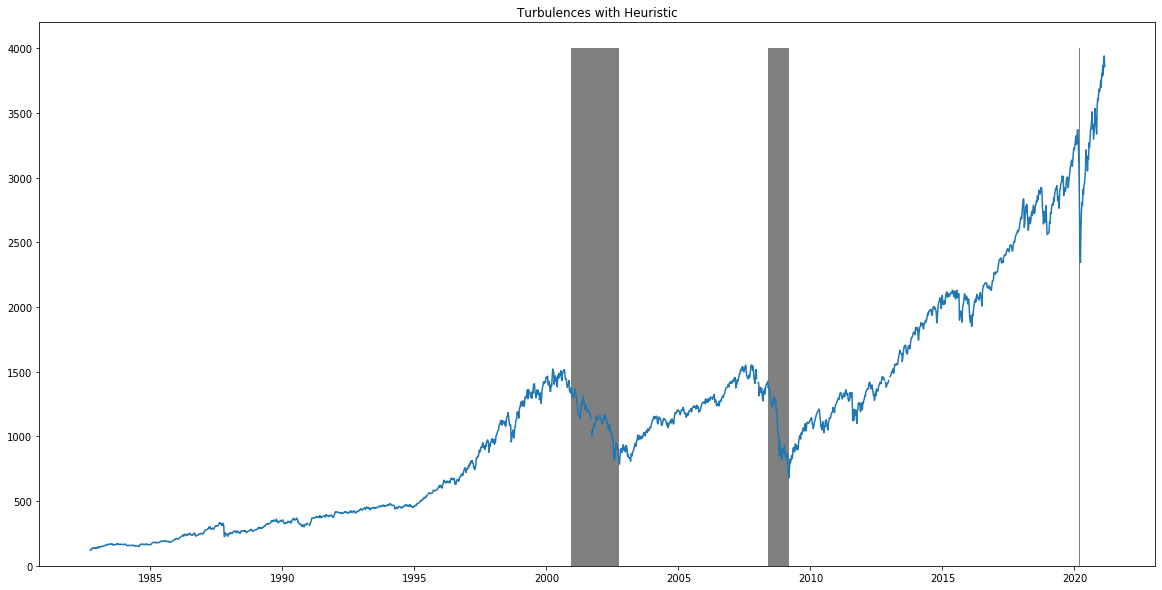

In [67]:
plt.figure(figsize=(20,10))
plt.plot(dta.index, dta.Price)
plt.bar(ccds, 4000, color= 'grey', width = 1)
plt.title("Turbulences with Heuristic")
plt.show()